# Forecast
***

**Author**: Chus Casado<br>
**Date**: 19-01-2023<br>

**Introduction**:<br>


**Questions**:<br>


**Tasks to do**:<br>


**Interesting links**<br>
[Pythonic way to perform statistics across multiple variables with Xarray](https://towardsdatascience.com/pythonic-way-to-perform-statistics-across-multiple-variables-with-xarray-d0221c78e34a)

In [1]:
import os
import glob
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
import cartopy.feature as cf
from datetime import datetime, timedelta
import seaborn as sns
from sklearn.metrics import f1_score, recall_score, precision_score, confusion_matrix

path_root = os.getcwd()
path_forecast = '../data/CDS/forecast/'

import warnings
warnings.filterwarnings("ignore")

os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd

os.chdir('../py/')
from notifications import *
os.chdir(path_root)

# 1 Data

In [2]:
catchment = 'Ebro'

# shapefile with rivers
rivers = gpd.read_file(f'../data/GIS/A3RIOS_{catchment}.shp')

### 1.1 Stations 

In [3]:
# load selected points
stations = pd.read_csv(f'results/{catchment}/points_selected.csv', index_col='station_id')
print('no. stations:\t{0}'.format(stations.shape[0]))

# add columns where skill will be saved
new_cols = [f'f1_{model}' for model in ['current', 'model_mean', 'grand_ensemble']]
stations[new_cols] = np.nan

no. stations:	50


### 1.2 Exceedance reanalysis

In [4]:
# load events
path_reanalysis = '../data/exceedance/reanalysis/'
rean_events = pd.read_parquet(f'{path_reanalysis}/events_rl5.parquet')
rean_events.columns = rean_events.columns.astype(int)
rean_events = rean_events[stations.index.tolist()]

### 1.3 Exceedance forecast

In [6]:
# models
models = {'COS': {'members': 20, 'leadtimes': 23},
          'DWD': {'members': 1, 'leadtimes': 29},
          'EUD': {'members': 1, 'leadtimes': 41},
          'EUE': {'members': 51, 'leadtimes': 41},}

In [7]:
# load exceedance data
path_forecast = '../data/exceedance/forecast/'

fore_exc = {}
for stn in stations.index:
    fore_exc[stn] = xr.open_dataarray(f'{path_forecast}{stn:04d}.nc')

# convert into a Dataset
stn = stations.index[0]
fore_exc = xr.Dataset(fore_exc, coords={'model': fore_exc[stn].model, 'forecast': fore_exc[stn].forecast, 'leadtime': fore_exc[stn].leadtime})

# convert the dataset into a DataArray in which models is a dimension instead of different variables
# da_list = [ds[stn].expand_dims('id', axis=0).assign_coords(id=[stn]).rename('exceedance') for stn in stations.index]
# da = xr.merge(da_list)['exceedance']

In [8]:
# DataArray with weights for each model and leadtime
weights = np.zeros((len(fore_exc.model), len(fore_exc.leadtime)))
for i, (key, value) in enumerate(models.items()):
    leadtimes = value['leadtimes']
    members = value['members']
    weights[i,:leadtimes] = members
weights = xr.DataArray(weights, coords={'model': list(models), 'leadtime': fore_exc.leadtime})

## 2 Prediction skill

In [9]:
# probability thresholds
probabilities = np.arange(0.1, 1., .1).round(1)
# number of timesteps surrounding the actual event
windows = np.arange(0, 5).astype(int)

# Dataset where results will be saved
results = xr.Dataset(coords={'model': ['current', 'model_mean', 'weighted_mean'],
                             'probability': probabilities,
                             'window': windows})

In [11]:
n_stations = stations.shape[0]
for i, stn in enumerate(stations.index):  
    
    print(f'Station {stn:>4d} ({i+1:>4d} of {n_stations:>4d})', end='\r')
    
    # array where station results will be saved temporarily
    results_station = np.zeros((len(results.model), len(results.probability), len(results.window))) * np.nan

    # find events
    mask = rean_events[stn]
    events = rean_events.index[mask].tolist()
    # create DataArray of the occurrence of events
    obs_events = dataarray_events(events, fore_exc.forecast, fore_exc.leadtime)

    # COMPUTE MODEL COMBINATIONS
    # ..........................

    # mean across equally-weighted models
    model_mean = fore_exc[stn].mean('model')
    model_mean = model_mean.expand_dims('model', axis=0).assign_coords(model=['model_mean']).rename(stn)

    # weighted-mean across models
    weighted_mean = fore_exc[stn].weighted(weights).mean('model')
    weighted_mean = weighted_mean.expand_dims('model', axis=0).assign_coords(model=['weighted_mean']).rename(stn)

    # join all exceedance DataArrays
    exceedance = xr.merge([fore_exc[stn], model_mean, weighted_mean])[stn]
    
    for j, p in enumerate(probabilities):
        
        # TIMSTEPS AT WHICH CRITERIA IS MET
        # .................................
        # dataset where all criteria will ve saved
        criteria = xr.Dataset(coords={'forecast': exceedance.forecast,
                                      'leadtime': exceedance.leadtime})

        # boolean auxiliary Dataset of exceedance over threshold
        aux = exceedance > p

        # find where the deterministic criteria was fulfilled
        deterministic = aux.sel(model=['DWD', 'EUD']).sum('model')
        # find where the probabilistic criteria was fulfilled
        probabilistic = aux.sel(model=['COS', 'EUE']).sum('model')
        # find where both the deterministic and the probabilistic criteria was fulfilled
        criteria['current'] = ((deterministic >= 1) & (probabilistic >= 1))
        # find where the combinations of models exceeds the probability threshold 
        for model in ['model_mean', 'weighted_mean']:
            criteria[model] = aux.sel(model=model)
        # remove variable model
        criteria = criteria.drop_vars('model')

        # FORECAST EVENTS
        # ...............

        # compute the onset of the events
        steps = criteria.astype(int).diff('leadtime') == 1
        step0 = criteria.isel(leadtime=0)
        fore_events = xr.concat((step0, steps), 'leadtime')
        
        # PERFORMANCE
        # -----------
        
        for k, w in enumerate(windows):
            # compute f1 score and add values to the station table
            f1 = compute_f1(obs_events, fore_events, window=w)
            results_station[:, j, k] = f1.max(axis=1).values
            
    results[stn] = xr.DataArray(results_station, coords=results.coords)

# merge all variables in a new dimension
da_list = [results[stn].expand_dims('id', axis=0).assign_coords(id=[stn]).rename('f1') for stn in list(results)]
results = xr.merge(da_list)['f1']

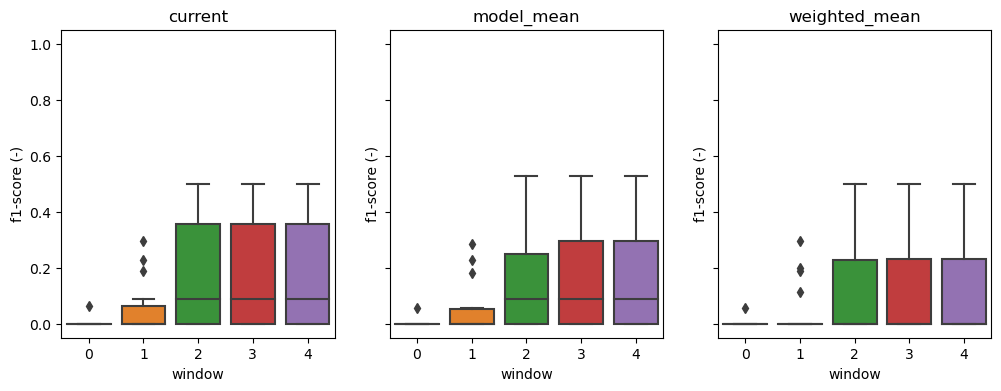

In [12]:
# stations with observed events
mask_stn = rean_events.sum() > 0
stations_ = stations.loc[mask_stn]

p = .5

ncols = len(results.model)

fig, axes = plt.subplots(ncols=ncols, figsize=(12, 4), sharex=True, sharey=True)

for ax, model in zip(axes, results.model.data):
    
    data = results.sel(id=stations_.index.to_list(), probability=p, model=model).data
    df = pd.DataFrame(data, index=stations_.index, columns=results.window)
    df['id'] = df.index
    df = pd.melt(df, id_vars='id', value_vars=[0, 1, 2, 3, 4])
    df.columns = ['id', 'window', 'f1']
    
    sns.boxplot(x=df.window, y=df.f1, ax=ax)
    
    ax.set(ylabel='f1-score (-)', ylim=(-.05, 1.05), title=model)

* The figures are very low even with a 4 timestep window, i.e., when we accept a 24 h error in the prediction of the onset of the event.
* The results are underrated because they take into account all leadtimes together. I should repeat the process grouping the f1 score by lead time.
* What if I simply check if a forecast predicts flooding (no matter when) and there actually was flooding during that forecast period.

***

**Daily resample**

In [ ]:
resample_dict = {'leadtime': 'd'}
events_daily = events_da.resample(resample_dict).any()
notification_d = xr.Dataset({variable: da.resample(resample_dict).any() for variable, da in notification.data_vars.items()})
notification_d = xr.Dataset(notification_d)

In [ ]:
fig, axes = plt.subplots(nrows=3, figsize=(16, 12), sharex=True)
for ax, (variable, da) in zip(axes, notification_d.data_vars.items()):
    heatmap_forecast(da, events, leadtime_grid=1, title=variable, ax=ax)
    heatmap_forecast(events_daily, vmax=2, cmap='Reds', alpha=.1, leadtime_grid=1, cbar=False, ax=ax)

In [ ]:
compute_performance(notification_d, events_daily)

**Rolling sum**

In [ ]:
w = 5
rolling_dict = {'leadtime': w}
mp = int(w / 2) + 1
notification_r = xr.Dataset({var: da.rolling(rolling_dict, center=True, min_periods=mp).sum() > 0 for var, da in notification.data_vars.items()})
events_r = events_da.rolling(rolling_dict, center=True, min_periods=mp).sum() > 0

In [ ]:
fig, axes = plt.subplots(nrows=3, figsize=(16, 12), sharex=True)
for ax, (variable, da) in zip(axes, notification_r.data_vars.items()):
    heatmap_forecast(da, events=None, vmax=2, title=variable, ax=ax)
    heatmap_forecast(events_da, vmax=2, cmap='Reds', alpha=.5, cbar=False, ax=ax)

In [ ]:
compute_performance(notification_r, events_da)

In [ ]:
compute_performance(notification_r, events_r)

In [ ]:
events_da.sum('leadtime')

In [ ]:
ev = events_da.isel(forecast=i)

In [ ]:
da = notification['model_mean']
da.sum('leadtime')

In [ ]:
i = 47

In [ ]:
y_true = events_da.isel(forecast=i).data.astype(float)

y_pred1 = da.isel(forecast=i).data.astype(float)
cm1 = confusion_matrix(y_true, y_pred1)

In [ ]:
y_pred0 = da.isel(forecast=i).shift(leadtime=1).data.astype(float)
y_pred0[0] = 0
cm0 = confusion_matrix(y_true, y_pred0)

In [ ]:
y_pred2 = da.isel(forecast=i).shift(leadtime=-1).data.astype(float)
y_pred2[-1] = 0
cm2 = confusion_matrix(y_true, y_pred2)

In [ ]:
np.max(cm0, cm1, cm2)

In [ ]:
# tmp = xr.DataArray([[0, 0, 1], [0, 1, 0], [1, 0, 0]], coords={'x': [1, 2, 3], 'y': [1, 2, 3]})
# tmp

# tmp.diff('y', label='upper')

# tmp.diff('y', label='lower')

## Compute formal notifications

* One probabilistic forecast (_EUE_ or _COSMO_) exceeds Q5:
    * With a probability of exceedance $\geq 30 \%$
    * In 3 consecutive forecasts
* One deterministic forecasts (_EUD_ or _DWD_) exceeds Q5
* Catchment area $\geq 2000 km^2$
* Lead time $\geq 48 h$

In [ ]:
stations_sel[['f1', 'recall', 'precision']] = np.nan
for i, (stn, Q5) in enumerate(zip(stations_sel.index, stations_sel.Q5)):

    ### REFORECAST

    # compute exceedance of Q5
    fore_exc = {model: compute_exceedance(files[model], stn, Q5) for model in models}
    # compute formal notifications
    notifications = compute_notifications(fore_exc, leadtime=4, probability=.3, persistence=3)

    ### REANALYSIS

    # Compute exceedance
    rea_exc = (reanalysis[stn] >= Q5).astype(int)

    # check if there was an event in each of the forecast windows
    events = []
    for forecast in notifications.forecast.values:
        start = forecast
        end = start + np.timedelta64(10, 'D')
        events.append(rea_exc[start:end].any())
    events = xr.DataArray(events, dims='forecast', coords={'forecast': notifications.forecast})

    # SKILL
    stations_sel.loc[stn, 'f1'] = f1_score(events, notifications)
    stations_sel.loc[stn, 'recall'] = recall_score(events, notifications)
    stations_sel.loc[stn, 'precision'] = precision_score(events, notifications)
    
    print('station {0:<3} of {1:<3} | {2:>4}:\t{3:.3f}'.format(i + 1, stations_sel.shape[0], stn, stations_sel.loc[stn, 'f1']))

In [ ]:
stations_sel[['f1', 'recall', 'precision']].describe()

In [ ]:
im = plt.scatter(stations_sel.LisfloodX, stations_sel.LisfloodY, s=stations_sel['DrainingArea.km2.LDD'] / 1000,
                 c=stations_sel.recall, cmap='virireanalysis', vmin=0, vmax=1)
plt.colorbar(im);

In [ ]:
stations_sel.loc[stations_sel.f1 == 0]

In [ ]:
stations_sel.to_csv(f'../data/stations_{catchment}.csv', float_format='%.3f')

For each station:
1. Identify flood events.
2